# Research Example: Generating evoproc_procedures for the GSM8K Dataset Using a Genetic Algorithm and OLLaMa Queries

## Step 1: Import packages and necessary application functions & variables

In [3]:
import os
import re
import math
import json
import pandas as pd
from hashlib import blake2b
import matplotlib.pyplot as plt
from datasets import load_dataset
from evoproc.ga_scaffold_structured import ProcedureGA, GAConfig
from evoproc.validators import validate_procedure_structured
from evoproc_procedures.models import Procedure
from evoproc_procedures.schemas import get_schema
from evoproc_procedures.prompts import create_procedure_prompt
from evoproc_procedures.ollama import query, repair_fn_ollama
from evoproc_procedures.runners import run_steps_stateful_minimal
from evoproc_procedures.helpers import pretty_print


## Step 2: Import the GSM8K Dataset

In [2]:
train_dataset = load_dataset("openai/gsm8k", "main", split="train")
test_dataset = load_dataset("openai/gsm8k", "main", split="test")

## Step 3: Set variable constants and instantiate necessary functions

In [3]:
FINAL_SCHEMA = get_schema("gsm")

In [4]:
def run_steps_fn(proc_json, question, final_answer_schema, model, print_bool=False):
    # use your general runner (backend-agnostic; pass Ollama query fn)
    state = run_steps_stateful_minimal(
        proc_json,
        problem_text=question,
        answer_schema=final_answer_schema,
        model=model,
        query_fn=query,
        print_bool=print_bool,
    )
    return state

def _extract_gold_number(gold_answer: str) -> float | None:
    # GSM8K gold answers are strings; often last number is the target
    nums = re.findall(r"-?\d+(?:\.\d+)?", gold_answer)
    return float(nums[-1]) if nums else None

def eval_fn(state, proc_json) -> float:
    """Return a fitness score in [0,1]."""
    # prefer model-extracted numeric if present, else try to parse its text
    pred_num = state.get("final_answer_numerical")
    if pred_num is None:
        try:
            pred_num = float(re.findall(r"-?\d+(?:\.\d+)?", state.get("final_answer",""))[-1])
        except Exception:
            return 0.0
    gold_num = state.get("_gold_num")  # we’ll inject this per item
    if gold_num is None:
        return 0.0
    # exact match or close within small tolerance
    return 1.0 if math.isclose(pred_num, gold_num, rel_tol=0, abs_tol=1e-6) else 0.0

## Step 3: Instantiate the Procedure Genetic Algorithm Object

In [5]:
ga = ProcedureGA(
    model="gemma3:latest",
    create_proc_fn=lambda task: create_procedure_prompt(task),
    query_fn=query,                                     # backend call
    schema_json_fn=lambda: Procedure.model_json_schema(),
    validate_fn=validate_procedure_structured,          # pure function
    repair_fn=repair_fn_ollama,                         # GA expects (proc, model) -> proc
    cfg=GAConfig(population_size=3, max_generations=3, crossover_rate=0.5, mutation_rate=0.5, seed=42),
)

## Step 4: For each Question-Answer pair, run the GA with the question as task_description

In [6]:
def _append_jsonl(path, items):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    with open(path, "a", encoding="utf-8") as f:
        for it in items:
            f.write(json.dumps(it, ensure_ascii=False) + "\n")
        f.flush()
        os.fsync(f.fileno())

def _load_existing_ids(path):
    ids = set()
    try:
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                    if "id" in rec and rec["id"] is not None:
                        ids.add(rec["id"])
                except json.JSONDecodeError:
                    # tolerate a partially written last line
                    continue
    except FileNotFoundError:
        pass
    return ids

def _stable_example_id(ex, *, salt=""):
    """
    Make a deterministic ID when dataset lacks 'id'.
    Uses question+answer (+ optional salt) to avoid changing if order changes.
    """
    # If a real id exists, reuse it
    if ex.get("id") is not None:
        return str(ex["id"])

    q = (ex.get("question") or "").strip()
    a = (ex.get("answer") or "").strip()
    h = blake2b(digest_size=16)  # 128-bit
    h.update(salt.encode("utf-8", "ignore"))
    h.update(q.encode("utf-8", "ignore"))
    h.update(b"\x1e")  # delimiter
    h.update(a.encode("utf-8", "ignore"))
    return h.hexdigest()

def _numbers_equal(a, b, tol=1e-9):
    if a is None or b is None:
        return False
    try:
        return abs(float(a) - float(b)) < tol
    except Exception:
        return a == b

def run_gsm8k_batch(
    examples,
    out_path=None,          # e.g., "runs/gsm8k_results.jsonl"
    save_every=10,          # write every N examples
    resume=False,           # skip examples whose IDs are already in out_path
    id_salt="",             # optional: add dataset name/split/version here for extra uniqueness
):
    """
    examples: iterable of dicts like {"question": "...", "answer": "..."} (GSM8K format)
    Returns: list of per-item result dicts with procedure, state, and score.
    Persists results to JSONL every `save_every`. If `resume=True`, skips already-saved IDs.
    """
    pending = []
    results = []
    existing_ids = _load_existing_ids(out_path) if (resume and out_path) else set()

    wrote_on_exception = False
    try:
        for idx, ex in enumerate(examples):
            qid = _stable_example_id(ex, salt=id_salt)
            if resume and out_path and (qid in existing_ids):
                continue

            question = ex["question"]
            gold_text = ex["answer"]
            gold_num = _extract_gold_number(gold_text)

            # ---- choose one path as before ----
            # # 1) Task-eval during GA:
            # best, history = ga.run(
            #     task_description=question,
            #     final_answer_schema=FINAL_SCHEMA,
            #     eval_fn=lambda state, proc: eval_fn({**state, "_gold_num": gold_num}, proc),
            #     run_steps_fn=run_steps_fn,
            #     print_progress=False,
            # )

            # 2) Hygiene-only during GA:
            best, history = ga.run(
                task_description=question,
                final_answer_schema=FINAL_SCHEMA,
                eval_fn=None,
                print_progress=False,
            )

            # Collect final state/answer
            final_state = run_steps_fn(best.proc, question, FINAL_SCHEMA, ga.model, print_bool=False)

            pred_ans = final_state.get("final_answer")
            pred_num = final_state.get("final_answer_numerical")

            # If you're not passing a real eval_fn, fall back to numeric equality.
            if 'eval_fn' in globals() and callable(globals()['eval_fn']):
                correct = bool(eval_fn({**final_state, "_gold_num": gold_num}, best.proc) >= 1.0)
            else:
                correct = _numbers_equal(pred_num, gold_num)

            rec = {
                "id": qid,                      # stable ID even without dataset-provided 'id'
                "row_index": idx,               # helpful for debugging
                "question": question,
                "gold_answer": gold_text,
                "gold_num": gold_num,
                "fitness": best.fitness,
                "procedure": best.proc,         # JSON dict
                "state": final_state,           # includes final answer(s)
                "pred_answer": pred_ans,
                "pred_num": pred_num,
                "correct": bool(correct),
                "steps": len(best.proc.get("steps", [])),
            }

            results.append(rec)
            if out_path:
                pending.append(rec)
                if len(pending) >= save_every:
                    _append_jsonl(out_path, pending)
                    pending.clear()

    except Exception:
        if out_path and pending:
            _append_jsonl(out_path, pending)
            pending.clear()
            wrote_on_exception = True
        raise
    finally:
        if out_path and pending and not wrote_on_exception:
            _append_jsonl(out_path, pending)
            pending.clear()

    return results


In [7]:
# For testing purposes, just grab first 10 as this will take a long time to run
first_ten = train_dataset.select(range(10))

In [8]:
# First run
results = run_gsm8k_batch(
    first_ten, 
    out_path="runs/gsm8k_train.jsonl", 
    save_every=5, 
    resume=False,
    id_salt="gsm8k-train-v1"   # optional but nice to set (dataset name/split/version)
)

# Resume after an interruption
# results = run_gsm8k_batch(
#     first_ten, 
#     out_path="runs/gsm8k_train.jsonl", 
#     save_every=10, 
#     resume=True,
#     id_salt="gsm8k-train-v1"
# )


In [9]:
read_results = None
with open("runs/gsm8k_train.jsonl", "r") as f:
    procs = [json.loads(line) for line in f]
    read_results = procs
    f.close()
first_ten_df = pd.DataFrame(read_results)

<Axes: xlabel='correct'>

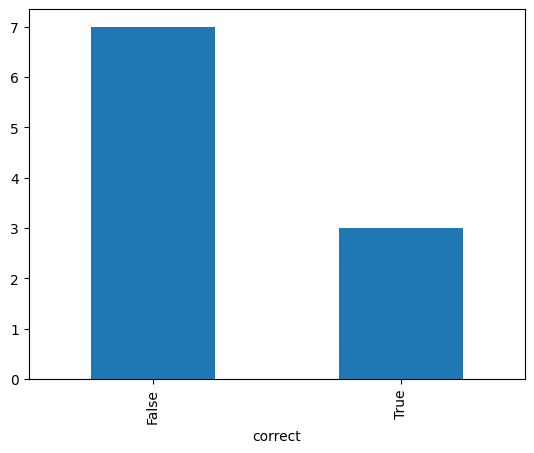

In [10]:
first_ten_df["correct"].value_counts().plot(kind='bar')

In [11]:
false_answers = first_ten_df[first_ten_df["correct"]==False]
for index, row in false_answers.iterrows():
    print(f"Question: {row['question']}")
    print(f"Gold Answer: {row['gold_answer']}")
    print(f"Predicted Answer: {row['pred_answer']}")
    print("Procedure:")
    pretty_print(row['procedure'])
    print("\n---\n")

Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
Gold Answer: In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.
Betty's grandparents gave her 15 * 2 = $<<15*2=30>>30.
This means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5 more.
#### 5
Predicted Answer: Betty needs $30 more to buy the wallet.
Procedure:

--- Procedure: Calculate how much more money Betty needs. ---
Steps:

Step 1: Extract the problem text from the input.
  **Inputs**:
    - problem_text: The problem description.
  **Outputs**:
    - problem_text: The problem description.

Step 2: Calculate the amount Betty has.
  **Inputs**:
    - problem_text: The problem description.
  **Outputs**:
    - money_she_has: The amount of money Betty has.

Step 3: Calculate the amount Betty needs.
  **

In [12]:
this = false_answers.iloc[1]
run_steps_fn(this['procedure'], this['question'], FINAL_SCHEMA, ga.model, print_bool=True)

[step 1] inputs: {'problem_text': 'Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?'}
[step 1] outputs: {k: state[k] for k in ['total_pages'] if k in state}
[step 2] inputs: {'total_pages': 120}
[step 2] outputs: {k: state[k] for k in ['yesterdays_pages'] if k in state}
[step 3] inputs: {'total_pages': 120, 'yesterdays_pages': 0}
[step 3] outputs: {k: state[k] for k in ['todays_pages'] if k in state}
[step 4] inputs: {'todays_pages': 120, 'yesterdays_pages': 0}
[step 4] outputs: {k: state[k] for k in ['tomorrows_pages'] if k in state}
[step 5] inputs: {'tomorrows_pages': 120}
[step 5] outputs: {k: state[k] for k in ['final_answer', 'final_answer_numerical', 'confidence', 'units'] if k in state}


{'problem_text': 'Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?',
 'total_pages': 120,
 'yesterdays_pages': 0,
 'todays_pages': 120,
 'tomorrows_pages': 120,
 'final_answer': 'Julie will read 120 pages tomorrow.',
 'final_answer_numerical': 120,
 'confidence': 1,
 'units': 'pages'}

In [13]:
false_answers["id"]

2    5ea421376648e9dd79cfbe0795691974
3    005bd9af151fa2a421d68bcab4a65f6b
4    46b52aae613b035a1aef1839a66a52f5
5    ac583ea43a6c74d49182df23d5c37828
6    ae555952684315fa7fe869f1b5c76115
8    35961f7131976b98f45a267c8b1b8f78
9    7a2ff0ffda6b1eebf1d6ce8ece6d2bbd
Name: id, dtype: object

In [14]:

# with open("runs/gsm8k_train.jsonl", "r") as f:
#     procs = [json.loads(line) for line in f]
#     for proc in procs:
#         txt = f"""
#                 Question: {proc['question']}
#                 Gold Answer: {proc['gold_answer']}
#                 Predicted Answer: {proc['pred_answer']}
#                 Correct: {proc['correct']}
#                 Fitness: {proc['fitness']}
#                 Steps: {proc['steps']}
#                 Procedure: {pretty_print(proc['procedure'])}
#                 """
#         print(txt)
#         print("\n")
#     f.close()
